In [1]:
import pandas as pd
import numpy as np
import yaml
import sys
import warnings
import ast

import pandas as pd
import plotly.figure_factory as ff
import plotly.subplots as sp
import plotly.express as px

import plotter as plot
import matplotlib.pyplot as plt

from pathlib import Path

from Stocks import Stock
from Portfolio import Portfolio
import distributions as dt
import returns as rt
import financial_ratios as fr
import optimizers as opt
import numpy as np
import prophet_helpers as ph
import timestamps as ts
import seaborn as sns
import montecarlo as mc


import scipy.stats as stats
from prophet import Prophet
from scipy.stats import lognorm

import pandas as pd
import numpy as np
from statsmodels.stats.multicomp import pairwise_tukeyhsd




warnings.simplefilter(action='ignore')

def read_yaml(file_name): 
    with open(file_name) as file:
        yaml_data= yaml.safe_load(file)
    return yaml_data


def common_random_numbers(size, seed=10):
    np.random.seed(seed)
    return np.random.rand(size)

def plot_multiple_peformance_distributions(performance_of_portfolio_configs_df, combinations, optimization_var, height=None, width=None):
    fig = sp.make_subplots()

    colors = px.colors.qualitative.Plotly

    for i in range(0, len(combinations)):
        combination_str = str(combinations[i])
        temp_df = performance_of_portfolio_configs_df[performance_of_portfolio_configs_df['portfolio_config'] == combination_str]

        hist_data = [temp_df[optimization_var]]
        group_labels = [combination_str]

        distplot = ff.create_distplot(hist_data, group_labels, show_hist=False, show_rug=False)
        for trace in distplot['data']:
            trace['line']['color'] = colors[i % len(colors)]
            fig.add_trace(trace)

    fig.update_layout(
        title=f'Distribution of {optimization_var}s across different Portfolio Configurations',
        xaxis_title=f'{optimization_var}',
        yaxis_title='Density',
        legend_title='Portfolio Configurations',
        height=height,
        width=width
    )

    fig.show()


    

def find_best_policy(performance_df, combinations, alpha=0.05, performance_metric='net_return'):
    """
    Find the best policy based on a specified performance metric using the Tukey HSD test.
    
    Parameters
    ----------
    performance_df : pd.DataFrame
        DataFrame containing the performance data of each policy.
    combinations : list
        List of unique policy combinations.
    alpha : float, optional, default: 0.05
        Significance level for the Tukey HSD test.
    performance_metric : str, optional, default: 'net_return'
        The performance metric to use for policy comparison ('net_return' or 'sharpe_ratio').
        
    Returns
    -------
    str
        The best policy based on the specified performance metric.
    """
    # Prepare the data for the Tukey HSD test
    performance_values = []
    policy_labels = []

    for i in range(len(combinations)):
        combination_str = str(combinations[i])
        temp_df = performance_df[performance_df['portfolio_config'] == combination_str]

        performance_values.extend(temp_df[performance_metric].tolist())
        policy_labels.extend([combination_str] * len(temp_df))

    # Perform the Tukey HSD test
    tukey_result = pairwise_tukeyhsd(performance_values, policy_labels, alpha=alpha)

    # Get the list of comparisons with significant differences
    significantly_different_comparisons = [comparison for comparison in tukey_result.reject if comparison]

    # Find the best policy
    best_policy = max(set(policy_labels), key=lambda policy: np.mean([performance_values[i] for i in range(len(performance_values)) if policy_labels[i] == policy]))

    return best_policy

def generate_combinations(step=0.2, target_sum=1.0, num_variables=3, precision=1):
    combinations = []
    num_steps = int(target_sum / step) + 1

    for i in range(num_steps):
        for j in range(num_steps - i):
            k = num_steps - i - j - 1
            if round(i * step, precision) + round(j * step, precision) + round(k * step, precision) == target_sum:
                combinations.append((round(i * step, precision), round(j * step, precision), round(k * step, precision)))

    return combinations



def simulate_portfolio_value(input_df, combination): 

    for i in range(0,len(combination)): 
        input_df[f'weight_{tickers[i]}'] = combination[i]

    for ticker in tickers: 
        input_df[f'{ticker}_num_stocks'] = initial_budget*input_df[f'weight_{ticker}'].iloc[0]/input_df[f'Close_{ticker}'].iloc[0]

    portfolio_values = []
    for i in range(0,len(input_df)): 
        portfolio_value = 0
        for ticker in tickers: 
            portfolio_value+= input_df[f'Close_{ticker}'].iloc[i] * input_df[f'{ticker}_num_stocks'].iloc[0]
        portfolio_values.append(portfolio_value)
    portfolio_values

    input_df['portfolio_value'] = portfolio_values

    return input_df

def merge_dfs(dfs): 

    merged_df = dfs[0].copy(deep=True)
    ticker = merged_df['ticker'].iloc[0]
    merged_df.rename(columns={'Close':f'Close_{ticker}'}, inplace=True)

    for i in range(1,len(dfs)): 
        temp_df =dfs[i].copy(deep=True)
        temp_ticker = temp_df['ticker'].iloc[0]
        temp_df.rename(columns={'Close':f'Close_{temp_ticker}'}, inplace=True)


        merged_df = pd.merge(merged_df, temp_df, left_index=True, right_index=True)
        
    return merged_df 




def get_choice_resource_allocation_df(choice_dia,choice_qqq, choice_spy, num_trading_days=30): 
    start_date = pd.to_datetime(dia_df.ticker_data.index)[-1]
    # num_trading_days = len(montecarlo_paths.T) # Generate 10 trading days
    trading_days = ts.get_trading_days(start_date, num_trading_days)
    # sim_df = pd.DataFrame({'date':trading_days, 'Close_QQQ': choice_qqq, 'Close_DIA':choice_dia, 'Close_SPY':choice_spy})
    # simulated_portfolio_df = simulate_portfolio_value(sim_df, combinations[2])
    # simulated_portfolio_df

    simulated_portfolio_values = []
    for i in range(0,len(combinations)): 
        sim_df = pd.DataFrame({'date':trading_days,'Close_DIA':choice_dia,  'Close_QQQ': choice_qqq, 'Close_SPY':choice_spy})
        simulated_portfolio_values.append((combinations[i], simulate_portfolio_value(sim_df, combinations[i])['portfolio_value']))


    simulated_portfolio_values_df_list = []
    for i in range(0,len(simulated_portfolio_values)): 

        price_data =simulated_portfolio_values[i][1]
        returns = (price_data / price_data.shift(1)) - 1
        returns = returns.iloc[1:]
        VaR = rt.historical_var(returns, confidence_level=0.95)
        cVaR = rt.historical_cvar(returns, confidence_level=0.95)
        sharpe_ratio = fr.get_sharpe_ratio(returns, risk_free_rate=0.02)
        sortino_ratio = fr.get_sortino_ratio(returns, risk_free_rate=0.02)

        simulated_portfolio_values_df_list.append(pd.DataFrame({'portfolio_config':[str(simulated_portfolio_values[i][0])], \
                                                                'mean':[np.mean(simulated_portfolio_values[i][1])], \
                                                                'var':[np.var(simulated_portfolio_values[i][1])], \
                                                                'std':[np.std(simulated_portfolio_values[i][1])],\
                                                                'VaR':[VaR], 'cVaR':[cVaR], 'sharpe_ratio':[sharpe_ratio],\
                                                                'sortino_ratio':[sortino_ratio]
                                                               }))

    simulated_portfolio_values_df = pd.concat(simulated_portfolio_values_df_list)
    simulated_portfolio_values_df['net_return'] = (simulated_portfolio_values_df['mean']-initial_budget)/initial_budget
    return simulated_portfolio_values_df


config = read_yaml('config.yaml')
# config['canadian_etfs_parsed']
canadian_etfs_parsed = config['canadian_etfs_parsed']
canadian_etfs_parsed



['VFV.TO']

<img src="Dataset_info.png" alt="Screenshot" width="800" height='400'/>

In [2]:
np.random.seed(10)

# Data Loading 

In [3]:
# start_dt = '2011-01-03'
# end_dt= '2015-04-13'
training_start_dt = '2015-01-01'
training_end_dt = '2020-12-31'

test_start_dt = '2021-01-01' 
test_end_dt = '2021-12-31'

out_of_sample_start_dt = '2022-01-01'
out_of_sample_end_dt = '2022-12-31'
tickers=[ 'DIA', 'QQQ', 'SPY' ]

dia_df = Stock('DIA', training_start_dt, training_end_dt)
# dia_df.ticker_data['ticker'] = 'diaA'

spy_df= Stock('SPY',training_start_dt, training_end_dt)
# spy_df.ticker_data['ticker'] = 'SPY'

qqq_df = Stock('QQQ', training_start_dt, training_end_dt)
# qqq_df.ticker_data['ticker'] = 'QQQ'

Pulling from yahoo
[*********************100%***********************]  1 of 1 completed
Pulling from yahoo
[*********************100%***********************]  1 of 1 completed
Pulling from yahoo
[*********************100%***********************]  1 of 1 completed


In [4]:
min_retrieve_dt = dia_df.ticker_data.index.min()
max_retrieve_dt = dia_df.ticker_data.index.max()
min_retrieve_dt, max_retrieve_dt

('2015-01-02', '2020-12-30')

# Portfolio Creation and Summary Statistics

In [5]:
p = Portfolio(tickers=[ 'DIA', 'QQQ', 'SPY' ], start_dt=min_retrieve_dt, end_dt=max_retrieve_dt)
cm = sns.light_palette("green", as_cmap=True) 
p.summary_statistics.style.background_gradient(cmap=cm)

Pulling from yahoo
[*********************100%***********************]  1 of 1 completed
Pulling from yahoo
[*********************100%***********************]  1 of 1 completed
Pulling from yahoo
[*********************100%***********************]  1 of 1 completed


,ticker,mean,variance,skewness,kurtosis,VaR,cVaR
0,DIA,0.000429,0.000149,-0.693342,21.993820,-0.019672,-0.033905
1,QQQ,0.000829,0.000182,-0.549800,10.104760,-0.021369,-0.033827
2,SPY,0.000461,0.000135,-0.718299,16.883935,-0.018637,-0.032000


In [6]:
p.correlation_matrix.style.background_gradient(cmap=cm)

,DIA,QQQ,SPY
DIA,1.000000,0.860586,0.974708
QQQ,0.860586,1.000000,0.926610
SPY,0.974708,0.926610,1.000000


In [7]:
df = p.all_stocks_df.copy(deep=True)
df.head()

,Open,High,Low,Close,Volume,ticker,pct_change,Cumulative_Percentage_Change,normalized_close,cumulative_mean_normalized_close,cumulative_variance_normalized_close,cumulative_std_normalized_close,skew,kurtosis,Jarque_Bera_stat,Jarque_Bera_p_val
2015-01-02,178.649994,179.229996,176.979996,177.940002,4997200,DIA,NaN,0.000000,0.145414,0.145414,0.000000,0.000000,-0.693342,21.99382,30535.30748,0.0
2015-01-05,177.059998,177.210007,174.460007,174.839996,6700200,DIA,-0.017422,-1.742164,0.124398,0.134906,0.000110,0.010508,-0.693342,21.99382,30535.30748,0.0
2015-01-06,175.100006,175.539993,172.320007,173.389999,10131400,DIA,-0.008293,-2.557043,0.114568,0.128127,0.000166,0.012866,-0.693342,21.99382,30535.30748,0.0
2015-01-07,174.850006,175.789993,174.240005,175.589996,5547000,DIA,0.012688,-1.320673,0.129483,0.128466,0.000124,0.011157,-0.693342,21.99382,30535.30748,0.0
2015-01-08,177.259995,178.960007,177.210007,178.759995,7166700,DIA,0.018053,0.460825,0.150973,0.132967,0.000181,0.013440,-0.693342,21.99382,30535.30748,0.0


In [8]:
tickers=[ 'DIA', 'QQQ', 'SPY' ]
dfs = [dia_df.ticker_data,spy_df.ticker_data, qqq_df.ticker_data]

    
merged_df =merge_dfs(dfs)
merged_df.head()

,Open_x,High_x,Low_x,Close_DIA,Volume_x,ticker_x,pct_change_x,Cumulative_Percentage_Change_x,normalized_close_x,cumulative_mean_normalized_close_x,...,pct_change,Cumulative_Percentage_Change,normalized_close,cumulative_mean_normalized_close,cumulative_variance_normalized_close,cumulative_std_normalized_close,skew,kurtosis,Jarque_Bera_stat,Jarque_Bera_p_val
2015-01-02,178.649994,179.229996,176.979996,177.940002,4997200,DIA,NaN,0.000000,0.145286,0.145286,...,NaN,0.000000,0.030556,0.030556,0.000000,0.000000,-0.549863,10.113303,6511.138584,0.0
2015-01-05,177.059998,177.210007,174.460007,174.839996,6700200,DIA,-0.017422,-1.742164,0.124289,0.134787,...,-0.014669,-1.466876,0.023586,0.027071,0.000012,0.003485,-0.549863,10.113303,6511.138584,0.0
2015-01-06,175.100006,175.539993,172.320007,173.389999,10131400,DIA,-0.008293,-2.557043,0.114468,0.128014,...,-0.013408,-2.788034,0.017309,0.023817,0.000029,0.005411,-0.549863,10.113303,6511.138584,0.0
2015-01-07,174.850006,175.789993,174.240005,175.589996,5547000,DIA,0.012688,-1.320673,0.129369,0.128353,...,0.012891,-1.534876,0.023263,0.023679,0.000022,0.004692,-0.549863,10.113303,6511.138584,0.0
2015-01-08,177.259995,178.960007,177.210007,178.759995,7166700,DIA,0.018053,0.460825,0.150840,0.132850,...,0.019140,0.349719,0.032218,0.025387,0.000029,0.005411,-0.549863,10.113303,6511.138584,0.0


<AxesSubplot:xlabel='pct_change', ylabel='Density'>

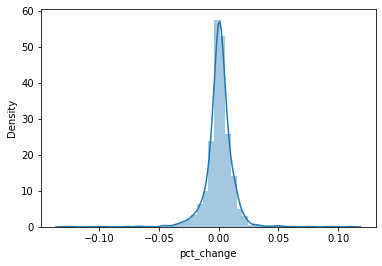

In [9]:
sns.distplot(dia_df.ticker_data['pct_change'].iloc[1:])

In [10]:
from scipy.stats import norm

def plot_qq_normal_plot(true_data, fitted_data, plot_title='True Data vs Normal'):
    plt.figure()
    stats.probplot(true_data, dist="norm", plot=plt, sparams=(mu, sigma))
    plt.title(plot_title)
    plt.xlabel('Theoretical Quantiles')
    plt.ylabel('Sample Quantiles')
    plt.show()
    


In [11]:
def plot_log_normal_fit_check(data, title=''): 

    # data = dia_df.ticker_data['pct_change'].iloc[1:]
    pdf_estimation = dt.estimate_pdf(data)
    pdf_fitted_lognormal = dt.get_fitted_pdf_log_normal(data)

    rmse = dt.rmse(pdf_estimation, pdf_fitted_lognormal)
    print(rmse)
    plt.plot(pdf_fitted_lognormal, label='LogNormal Fit on Data')
    plt.plot(pdf_estimation, label='True Data PDF')
    plt.title(title)
    plt.legend()
    plt.show()

    shape, loc, scale = lognorm.fit(data)
    # Create the lognormal distribution with the fitted parameters
    fitted_lognorm = lognorm(s=shape, loc=loc, scale=scale)
    fitted_data=  fitted_lognorm.rvs(100000)

    dt.plot_qq_plot(data, fitted_data, plot_title=title)
    


def plot_normal_fit_check(data, title=''): 
    mu, sigma = np.mean(data), np.std(data)
    fitted_normal = stats.norm(loc=mu, scale=sigma)
    fitted_data = fitted_normal.rvs(100000)

    pdf_estimation = dt.estimate_pdf(data)
    pdf_fitted_normal = dt.get_fitted_pdf_normal(data)

    rmse = dt.rmse(pdf_estimation, pdf_fitted_normal)
    print(f"rmse:{rmse}")
    plt.plot(pdf_fitted_normal, label='Normal Fit on Data')
    plt.plot(pdf_estimation, label='True Data PDF')
    plt.title(f"Comparison of PDF of True Data vs other distributions, rmse:{np.round(rmse,2)}")
    plt.legend()
    plt.show()
    
    dt.plot_qq_plot(data, fitted_data, plot_title=title)    

In [12]:
tickers

['DIA', 'QQQ', 'SPY']

rmse:4.491334970532698


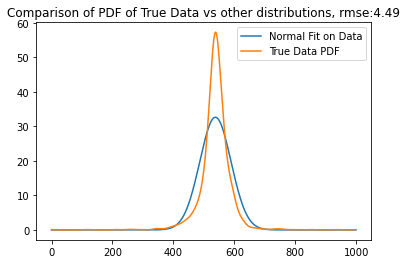

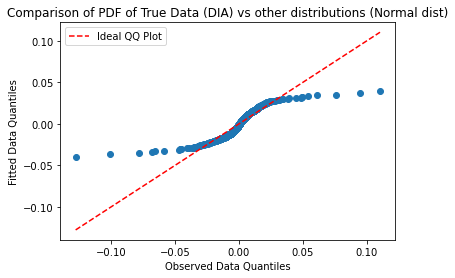

4.482573055037583


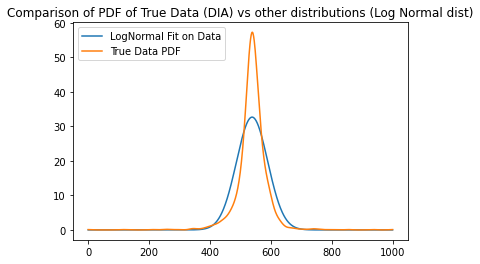

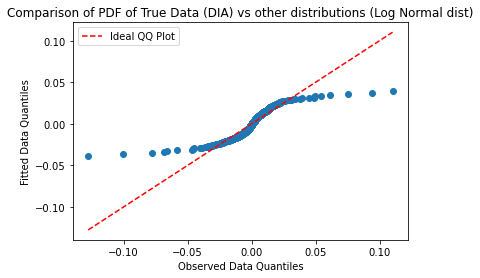

rmse:3.6908662299157937


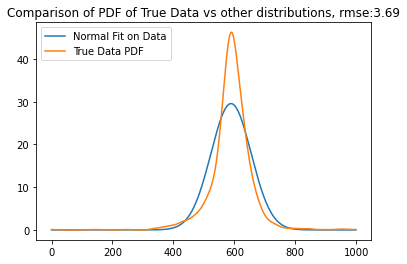

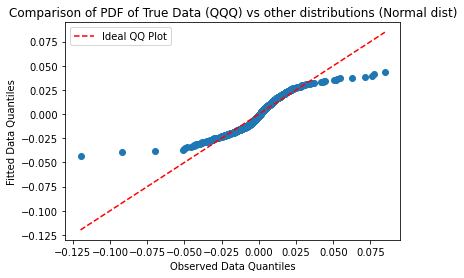

3.681751626145781


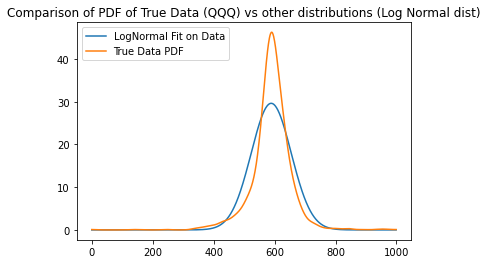

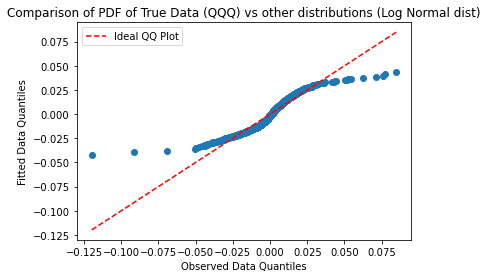

rmse:4.719857513393174


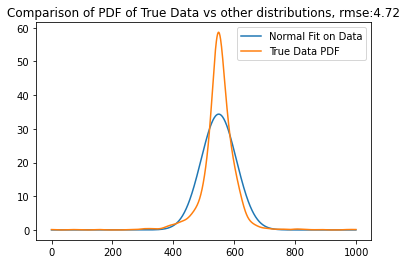

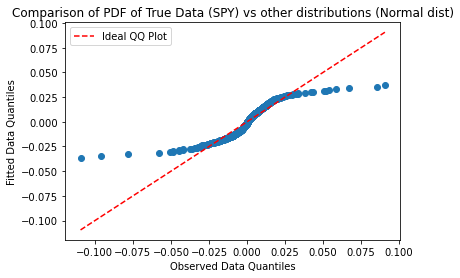

4.708670715933008


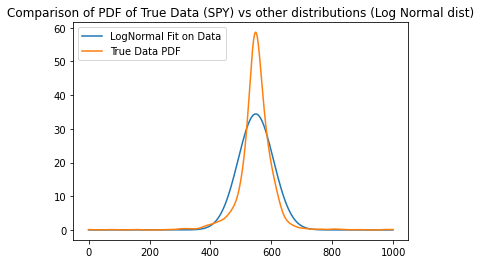

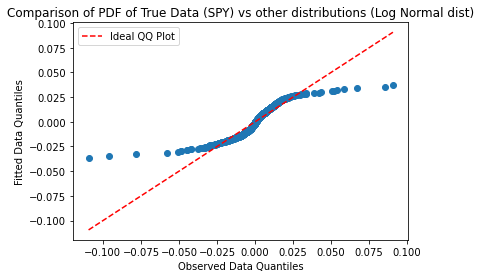

In [13]:

    
    
data = dia_df.ticker_data['pct_change'].iloc[1:]  # Replace with your actual data
plot_normal_fit_check(data, title=f"Comparison of PDF of True Data (DIA) vs other distributions (Normal dist)" )
plot_log_normal_fit_check(data, title=f"Comparison of PDF of True Data (DIA) vs other distributions (Log Normal dist)" )




data = qqq_df.ticker_data['pct_change'].iloc[1:]  # Replace with your actual data
plot_normal_fit_check(data, title=f"Comparison of PDF of True Data (QQQ) vs other distributions (Normal dist)" )
plot_log_normal_fit_check(data, title=f"Comparison of PDF of True Data (QQQ) vs other distributions (Log Normal dist)" )



data = spy_df.ticker_data['pct_change'].iloc[1:]  # Replace with your actual data
plot_normal_fit_check(data, title=f"Comparison of PDF of True Data (SPY) vs other distributions (Normal dist)" )
plot_log_normal_fit_check(data, title=f"Comparison of PDF of True Data (SPY) vs other distributions (Log Normal dist)" )